# The Different GPS Test using Choi Control Invariant
This notebook looks at how well the Choi control invariant model detects
the sensor spoofing attacks.

The data files can be found in the src\choi\ subdirectory. Only interim data will be
available on github to preserve storage. For raw log files please contact me at
xxxxxxx.

## Choi Control Invariant
The Choi Control Invariant is a model for detecting attacks on sensor published in
CCS 2018. A link to the paper can be found here:
https://friends.cs.purdue.edu/pubs/CCS18.pdf

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget


import numpy as np
import pandas as pd
from tqdm.notebook import trange
from IPython.display import clear_output
from math import ceil

def choi(target, measure):
    #Model Parameters
    WindowSize = ceil(11*10) # seconds * updates/second in main loop
    ErrorThreshold = 10262   # Choi multiply by 100*100 in the ArduPilot implementation
                             # because the logs record in degrees while the AHRS backend
                             # treats the data as centidegrees. We don't need to scale
    
    A = np.array([[-0.000000018536, -0.0176, -0.0074],
                 [0.0000010503, 1.0000, -0.00018407],
                 [0.0000000026247, 0.0025, 1.0000]], dtype=float)
    B = np.array([[0.0000010503],
                  [0.0000000026247],
                  [0.0000000000032796]], dtype=float)
    C = np.array([2.2332, -0.7369, -0.6200], dtype=float)
    D = 0
    
    err_sum = 0 #accumulated errors
    w_index = 0 #current index in window
    max_mse = 0 #max error
    inv_x = np.array([[0.0],
                      [0.0],
                      [0.0]], dtype=float)
    MSEs = []
    #Go through the dataset
    for index in trange(len(target), desc="Processing dataframe"):
        # y = Cx[i] + Du[i]
        inv_y = np.matmul(C, inv_x) + D*target[index]
        
        # x' = Ax[i] + Bu[i]
        inv_x = np.matmul(A, inv_x) + B*target[index]
        
        # error calculation
        error = inv_y - measure[index]
        err_sum += error**2
        mse = err_sum / (w_index + 1)
        if mse > max_mse:
            max_mse = mse
        w_index+=1
        if w_index >= WindowSize:
            w_index = 0
            err_sum = 0
        MSEs.append(mse[0])
    clear_output()
    return(MSEs)

## 1) Loading 2.5m offset with 0.10 m/s/s slow rate Data

In [2]:
#Read in data file
data_dir = "../src/choi/"
file = "Flight (3).csv"
df = pd.read_csv(data_dir + file)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)
df['TimeUS'] = pd.to_datetime(df['TimeUS'], unit='us')

attack_start = []
attack_end = []
attack_start.append(pd.to_datetime(328596249, unit='us'))
attack_end.append(pd.to_datetime(335236417, unit='us'))

df = df[df['TimeUS'] < attack_end[-1]].reset_index(drop=True)
TimeUS = []
TimeUS.append(df.TimeUS)

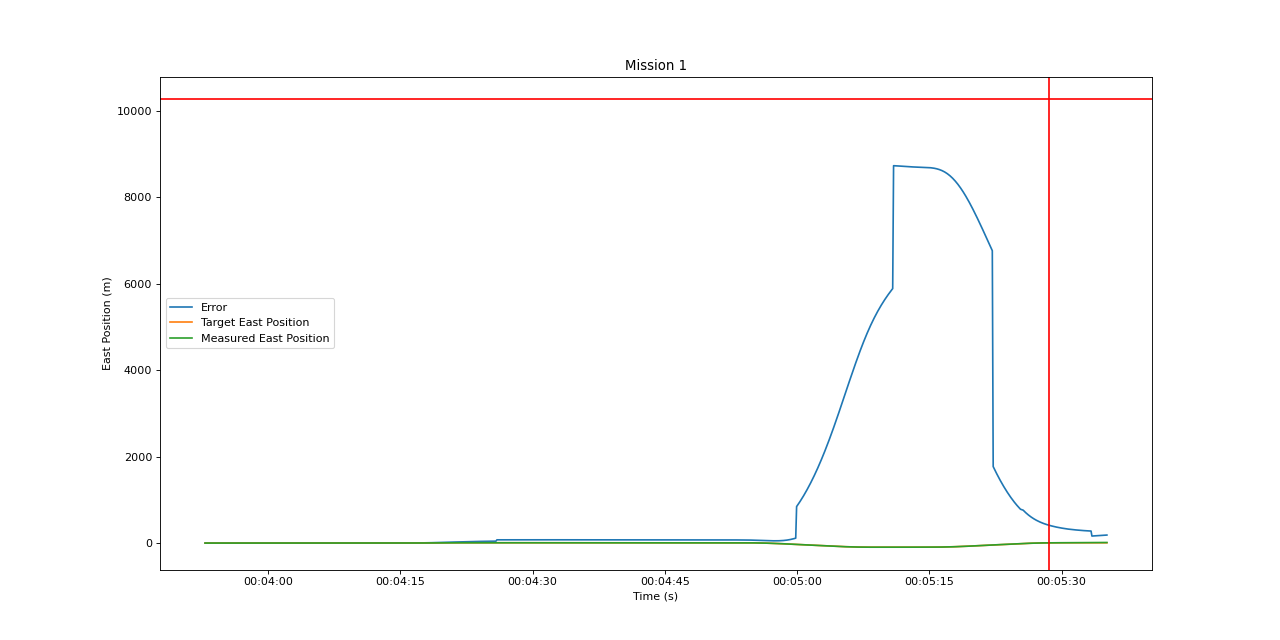

In [3]:
import matplotlib.pyplot as plt
MSEs = []

MSEs.append(choi(df.TPN, df.PN))
plt.figure(figsize=(16, 8), dpi=80)
plt.plot(df.TimeUS, MSEs[-1], label="Error")
plt.plot(df.TimeUS, df.TPN, label="Target East Position")
plt.plot(df.TimeUS, df.PN, label="Measured East Position")
plt.axvline(attack_start[-1], color='r')
plt.axhline(10262, color='r')
plt.xlabel("Time (s)")
plt.ylabel("East Position (m)")
plt.title("Mission 1")
plt.legend()

## 2) Loading 2.5m offset with 0.10 m/s/s slow rate Data

In [4]:
#Read in data file
data_dir = "../src/choi/"
file = "Flight (4).csv"
df = pd.read_csv(data_dir + file)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)
df['TimeUS'] = pd.to_datetime(df['TimeUS'], unit='us')

attack_start.append(pd.to_datetime(413945026, unit='us'))
attack_end.append(pd.to_datetime(421837977, unit='us'))
df = df[df['TimeUS'] < attack_end[-1]].reset_index(drop=True)
TimeUS.append(df.TimeUS)

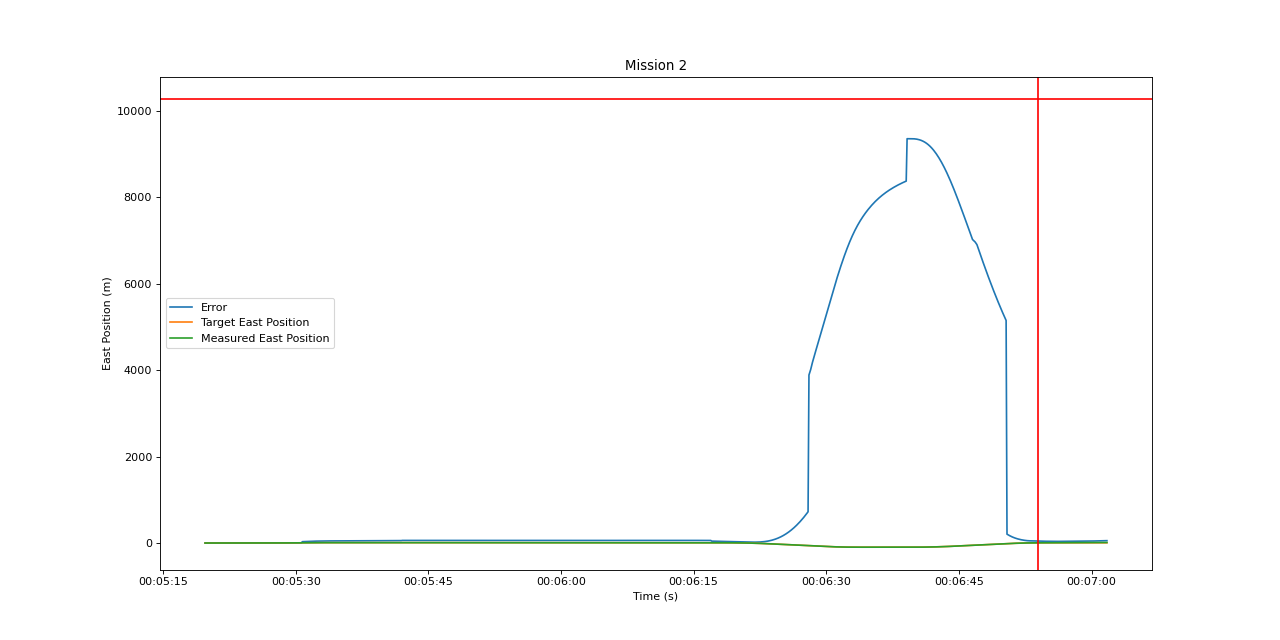

In [5]:
MSEs.append(choi(df.TPN, df.PN))
plt.figure(figsize=(16, 8), dpi=80)
plt.plot(df.TimeUS, MSEs[-1], label="Error")
plt.plot(df.TimeUS, df.TPN, label="Target East Position")
plt.plot(df.TimeUS, df.PN, label="Measured East Position")
plt.axvline(attack_start[-1], color='r')
plt.axhline(10262, color='r')
plt.xlabel("Time (s)")
plt.ylabel("East Position (m)")
plt.title("Mission 2")
plt.legend()

## Both of the MSEs plotted together

In [6]:
from matplotlib import dates

for i in range(len(TimeUS)):
    attack_start[i] -= TimeUS[i][0]
    attack_start[i] = float(attack_start[i].seconds)
    TimeUS[i] = TimeUS[i] - TimeUS[i][0]
    TimeUS[i] = [i.total_seconds() for i in TimeUS[i]]

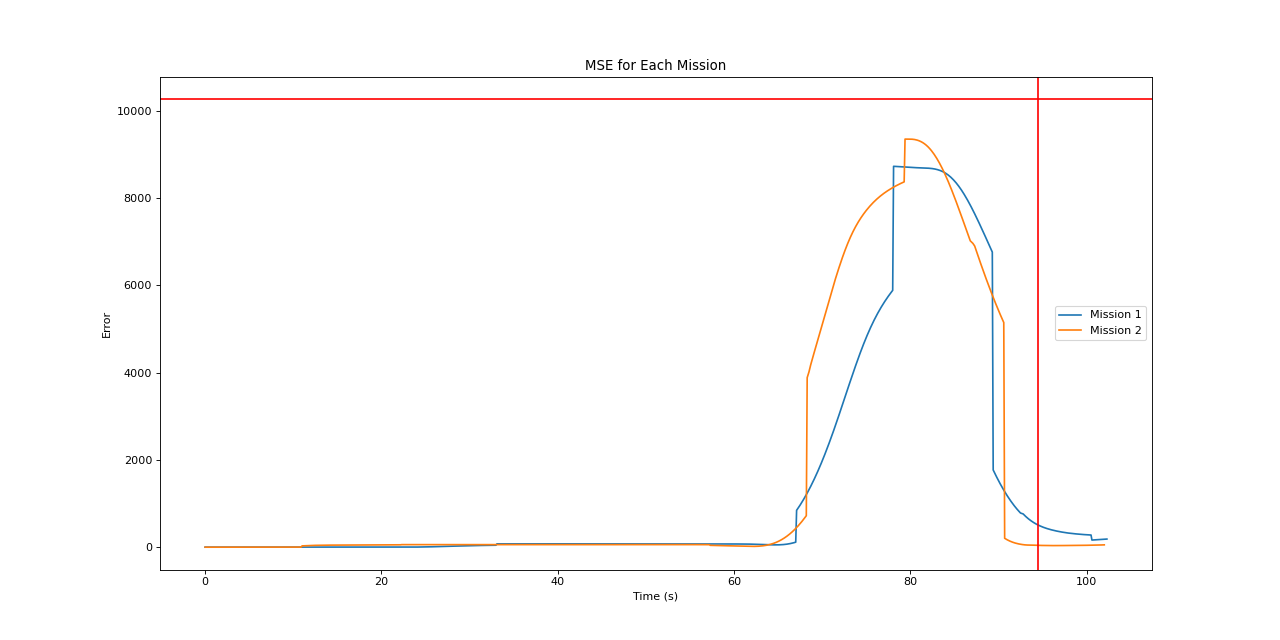

In [7]:
from statistics import mean

plt.figure(figsize=(16, 8), dpi=80)
for i in range(len(MSEs)):
    plt.plot(TimeUS[i], MSEs[i], label="Mission %i" % (i+1))
plt.axhline(10262, color='r')
plt.axvline(mean(attack_start), color='r')
plt.xlabel("Time (s)")
plt.ylabel("Error")
plt.title("MSE for Each Mission")
plt.legend()

## 3) A One-step Attack with Choi CI

In [8]:
#Read in data file
data_dir = "../src/choi/"
file = "onestep_loiter_2m.csv"
df = pd.read_csv(data_dir + file)

#All of the data is numeric and should be treated as such
df = df.apply(pd.to_numeric)

#Set index to be the timestamps so we can drop duplicate rows
#then reset index to be row number
df.set_index("TimeUS",inplace=True)
df = df.drop_duplicates()
df.reset_index(inplace=True)
df['TimeUS'] = pd.to_datetime(df['TimeUS'], unit='us')

attack_start.append(pd.to_datetime(262990960, unit='us'))
attack_end.append(pd.to_datetime(272990960, unit='us'))

df = df[df['TimeUS'] < attack_end[-1]].reset_index(drop=True)
TimeUS.append(df.TimeUS)

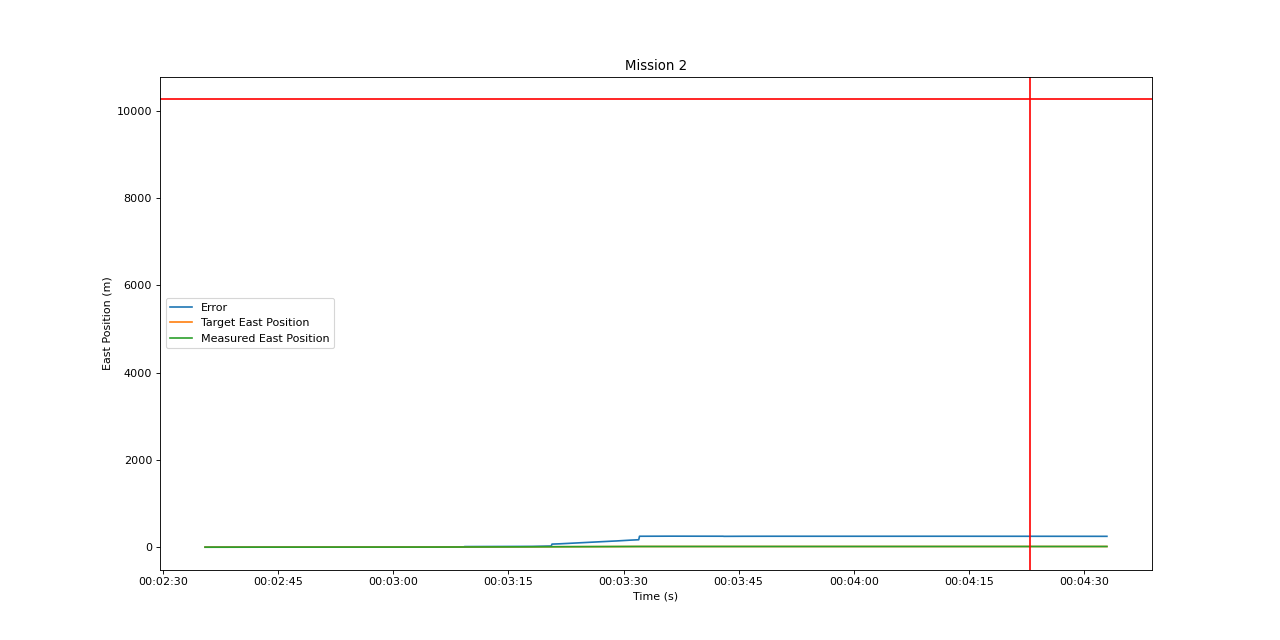

In [9]:
MSEs.append(choi(df.TPN, df.PN))
plt.figure(figsize=(16, 8), dpi=80)
plt.plot(df.TimeUS, MSEs[-1], label="Error")
plt.plot(df.TimeUS, df.TPN, label="Target East Position")
plt.plot(df.TimeUS, df.PN, label="Measured East Position")
plt.axvline(attack_start[-1], color='r')
plt.axhline(10262, color='r')
plt.xlabel("Time (s)")
plt.ylabel("East Position (m)")
plt.title("Mission 2")
plt.legend()